# Lecture 16 - (Part 1) Soft-Margin Support Vector Machines & SVMs for Regression Tasks. (Part 2) The Curse of Dimensionality.

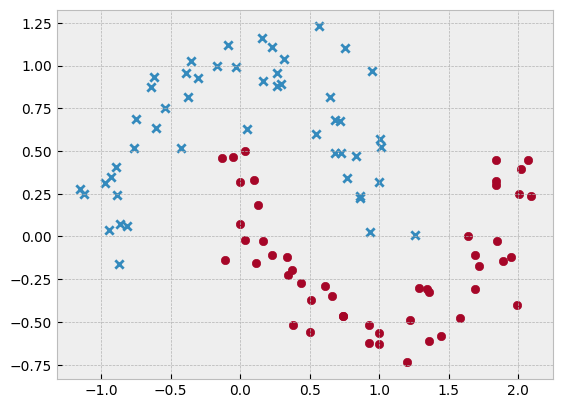

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')
from sklearn.datasets import make_blobs, make_moons
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

X, t = make_moons(n_samples=100, noise=0.15, random_state=0)
plt.scatter(X[t==0,0], X[t==0,1], marker='x')
plt.scatter(X[t==1,0], X[t==1,1]);

In [2]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()] #ravel() is a NumPy function that flattens an array into 1 dimension.
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

def plot_dataset(X, t, axes):
    plt.plot(X[:, 0][t==0], X[:, 1][t==0], "bs")
    plt.plot(X[:, 0][t==1], X[:, 1][t==1], "g^")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

In [3]:
poly_svm_clf = Pipeline([('scaler', StandardScaler()),
                         ('svm', SVC(kernel='poly', degree=3, 
                                     C=10, coef0=1))])
poly_svm_clf.fit(X, t)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(C=10, coef0=1, kernel='poly'))])

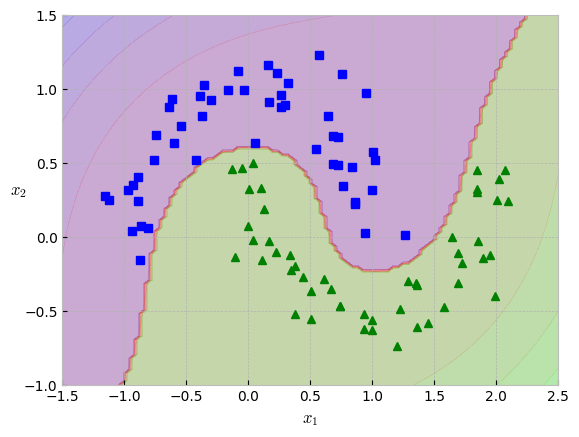

In [4]:
plot_predictions(poly_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, t, [-1.5, 2.5, -1, 1.5])

### Gaussian RBF Kernel

A popular kernel function is the **radial basis function** (RBF kernel):

\begin{align*}
k_{\text{RBF}}(\mathbf{x},\mathbf{y}) &= \exp\left(-\gamma\Vert\mathbf{x}-\mathbf{y}\Vert^2\right)
\end{align*}

typical values for $\gamma=\frac{1}{2\sigma^2}$. As you can see, the RBF kernel is measures the **similarity** between two points as a function of the kernel **bandwidth** $\sigma$.

Let's try the ```SVC``` class with the Gaussian RBF kernel:

In [5]:
rbf_svm_clf = Pipeline([('scaler', StandardScaler()),
                        ('svm', SVC(kernel='rbf', gamma=5,
                                    C=0.001))])
rbf_svm_clf.fit(X,t)

Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC(C=0.001, gamma=5))])

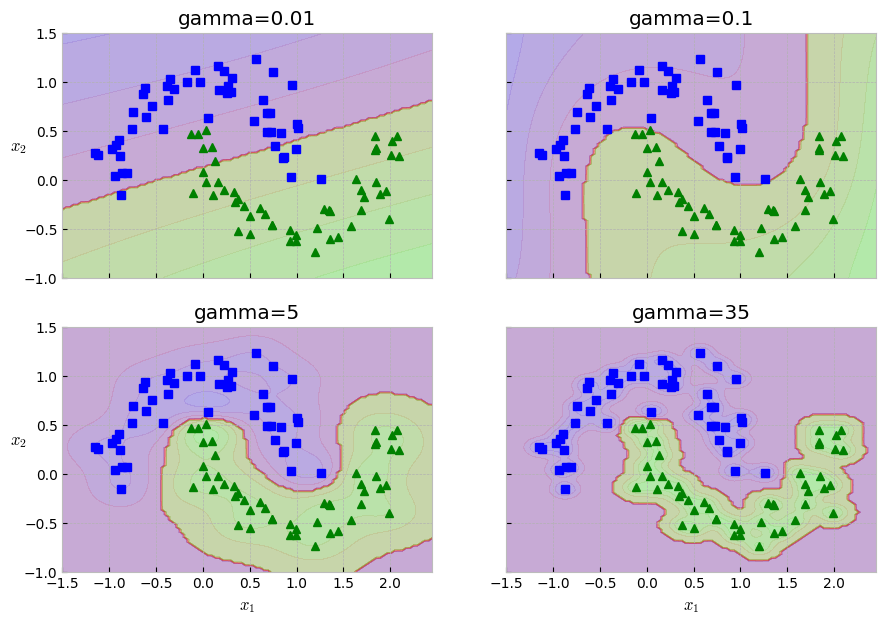

In [6]:
gamma_vals = [0.01, 0.1, 5, 35]

svm_clfs = []
for gamma in gamma_vals:
    rbf_kernel_svm_clf = Pipeline([('scaler', StandardScaler()),
                                   ('svm', SVC(kernel='rbf', 
                                               gamma=gamma,
                                               C=100))])
    rbf_kernel_svm_clf.fit(X, t)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, t, [-1.5, 2.45, -1, 1.5])
    gamma = gamma_vals[i]
    plt.title(f"gamma={gamma}")
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("");

# Computational Complexity

The ```SVC``` class is based on the ```libsvm``` library, which implements an algorithm that supports the kernel trick. The training time complexity is usually between $O(m^2\times N)$ and $O(m^3 \times N)$, where $M$ is the number of features and $N$ is the number of samples. Unfortunately, this means that it gets dreadfully **slow when the number of training samples gets large** (e.g., hundreds of thousands of samples). 

This algorithm is perfect for complex small or medium-sized training sets. It scales well with the number of features, especially with sparse features (i.e., when each instance has few nonzero features). In this case, the algorithm scales roughly with the average number of nonzero features per instance.

---

In [7]:
# Helper function
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, edgecolors='black',facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

# Multi-Class SVM

SVM uses a one-vs-all approach and picks the class for which the confidence (distance) is largest from its hyperplane.

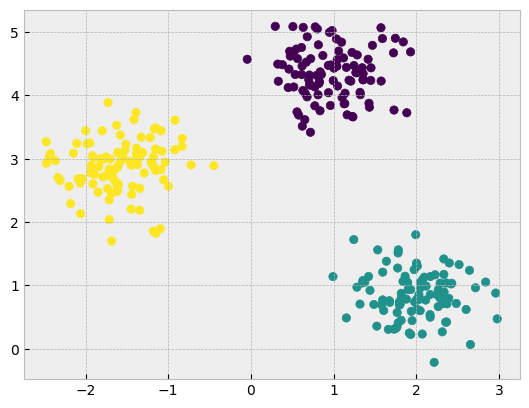

In [8]:
X, t = make_blobs(n_samples=300, centers=3,
                  random_state=0, cluster_std=0.40)

plt.scatter(X[:, 0], X[:, 1], c=t);

In [9]:
np.unique(t, return_counts=True)

(array([0, 1, 2]), array([100, 100, 100], dtype=int64))

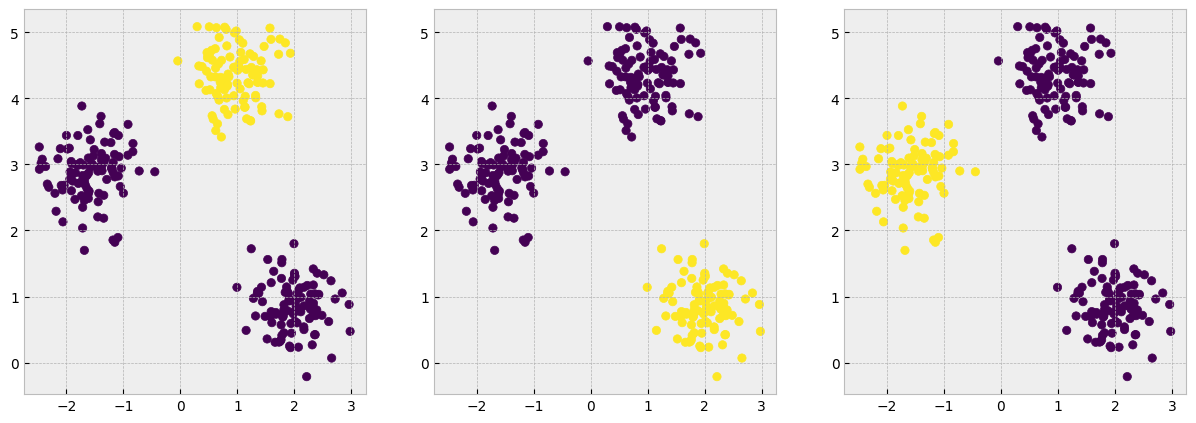

In [10]:
t0 = 1*(t==0)
t1 = 1*(t==1)
t2 = 1*(t==2)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.scatter(X[:, 0], X[:, 1], c=t0)
plt.subplot(1,3,2); plt.scatter(X[:, 0], X[:, 1], c=t1)
plt.subplot(1,3,3); plt.scatter(X[:, 0], X[:, 1], c=t2);

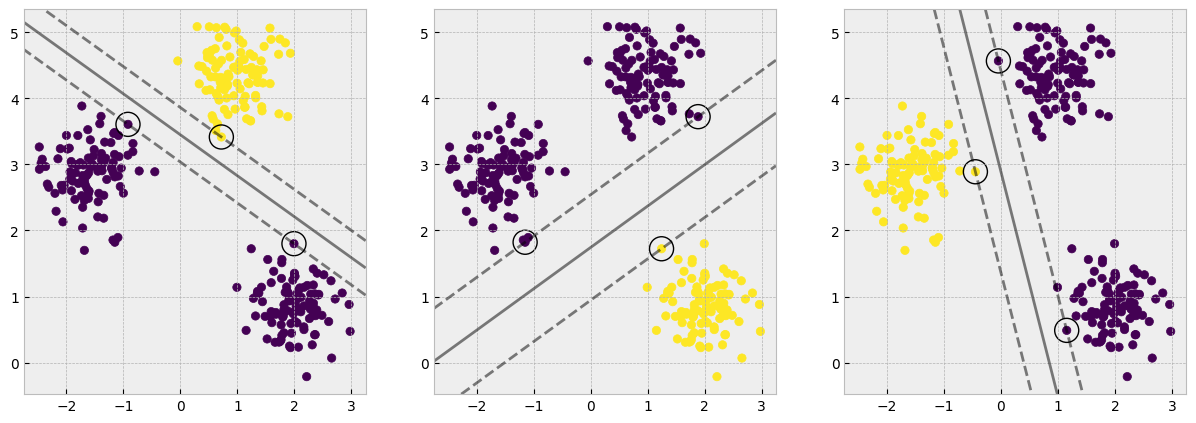

In [11]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1); plt.scatter(X[:, 0], X[:, 1], c=t0)
svm0 = SVC(kernel='linear', C=1E6, random_state=0)
svm0.fit(X, t0)
plot_svc_decision_function(svm0)

plt.subplot(1,3,2); plt.scatter(X[:, 0], X[:, 1], c=t1)
svm1 = SVC(kernel='linear', C=1E6, random_state=0)
svm1.fit(X, t1)
plot_svc_decision_function(svm1)

plt.subplot(1,3,3); plt.scatter(X[:, 0], X[:, 1], c=t2)
svm2 = SVC(kernel='linear', C=1E6, random_state=0)
svm2.fit(X, t2)
plot_svc_decision_function(svm2);

In [12]:
x = [[0,0]]

In [13]:
# y value
svm0.decision_function(x)

array([-8.36361151])

In [14]:
svm1.decision_function(x)

array([2.18343514])

In [15]:
svm2.decision_function(x)

array([1.89254495])

This point will be labeled as class 1.

In [16]:
svm_all = SVC(kernel='linear', random_state=0)
svm_all.fit(X,t)

SVC(kernel='linear', random_state=0)

In [17]:
svm_all.predict(x)

array([1])

In [18]:
svm_all.decision_function(x)

array([[-0.28163501,  2.25805685,  1.22294132]])

# Soft-Margin Support Vector Machine (SVM): Overlapping Classes

If we strictly impose that all samples must be off the street and on the right side, this is called hard margin classification. There are two main issues with hard margin classification. First, it only works if the data is linearly separable. Second, it is sensitive to outliers.

To avoid these issues, use a more flexible model. The objective is to find a good balance between keeping the street as large as possible and **limiting the margin violations** (i.e., samples that end up in the middle of the street or even on the wrong side). This is called **soft margin classification**.

When creating an SVM model using Scikit-Learn, we can specify a number of hyperparameters. ```C``` is one of those hyperparameters. If we set it to a low value, then we end up with the model with many margin violations. With a high value, the model converges to a hard margin SVM. Margin violations are bad. It’s usually better to have few of them. However, in some cases, a lot of margin violations might be better to obtain a generalizable model.

* If your SVM model is overfitting, you can try regularizing it by reducing ```C```.

## Slack Variables

The margin violations are handled by **slack variables**.

The soft-margin SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit. The hardness of the margin is controlled by a tuning parameter, most often known as **slack varible** $\xi_n \geq 0$, $n=1,\dots, N$, with one slack variable for each training data point. For very large $\xi$, the margin is hard, and points cannot lie in it. For smaller $\xi$, the margin is softer, and can grow to encompass some points.

Our goal is now to maximize the margin while softly penalizing points that lie on the wrong side of the margin boundary. We therefore minimize:

\begin{align*}
&\arg_{w,b} \min \frac{1}{2} \Vert w\Vert^2 + C\sum_{n=1}^N \xi_n\\
\text{subject to    } &t_n y(x_n) \geq 1 - \xi_n, n = 1, \dots, N\\
\text{and    } &\xi_n \geq 0, n = 1, \dots, N
\end{align*}

where the parameter $C>0$ controls the trade-off between the slack variable penalty and the margin.

* Because any point that is misclassified has $\xi_n >1$, it follows that $\sum_n \xi_n$ is an upper bound on the number of misclassified points. 
* The parameter $C$ is therefore analogous to (the inverse of) a regularization coefficient because it controls the trade-off between minimizing training errors and controlling model complexity.
* In the limit $C \rightarrow \infty$, we will recover the earlier support vector machine for separable data.

---------------------------------
Here is the **baby-language, super-easy explanation** of the whole thing:

---

# 🍼 **Slack Variables in SVM — Baby Language Version**

Imagine you are drawing a line to separate **blue dots** and **green triangles**.

You want:

* The line to be *as far as possible* from all points (big margin = good).
* But in real life, **some dots are messy** and don’t sit perfectly on their side.

So what do we do?

---

# 🧸 **Slack Variables = “Oops! Allowance”**

A **slack variable** (ξ, pronounced *xi*) is like giving a point a small **“oops pass”**:

👉 *“Okay little point, you are allowed to come a bit inside the margin.”*
👉 *“Okay, maybe even make a small mistake.”*

So each point gets a number ξₙ:

* ξₙ = 0 → perfect, behaves nicely
* 0 < ξₙ < 1 → inside margin but still on the correct side
* ξₙ > 1 → completely on the wrong side (misclassified)

It’s like giving each student a **behavior score**:

* 0 = very good
* 1 or more = being naughty

---

# 🍼 **What is C?**

`C` is a **strict teacher**.

* **Big C** = strict teacher → *“No mistakes allowed!!”*

  * The margin becomes **hard**.
  * Fewer slack variables allowed.
  * Model tries to classify everything perfectly.
* **Small C** = chill teacher → *“It’s okay, make some mistakes.”*

  * The margin becomes **soft**.
  * More slack variables allowed.
  * Model is more flexible.

---

# 🍭 **The Formula (in baby words)**

The SVM tries to:

### ✔ Make the margin big

### ✔ Allow a few mistakes

### ✔ But punish too many mistakes

So the objective is:

[
\frac12 |w|^2 \quad + \quad C \sum \xi_n
]

Baby meaning:

* First term = “make the line margin big”
* Second term = “punish naughty points”
* `C` = “how angry the teacher gets at naughty points”

---

# 🍼 **Main idea in one sentence**

**Slack variables allow some points to break the margin rule, and C controls how much the SVM cares about those mistakes.**

-------------------------

In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.datasets import make_blobs, make_moons
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [20]:
# Helper function
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, edgecolors='black',facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

Here is a **very simple, clear explanation** of what this function does — line by line — in *easy language*.

---

# 🌈 **Big Picture**

This function **draws the SVM decision boundary and margins**

* optionally plots **support vectors**.

So after training your SVM, you call this to *visualize* the separating line.

---

# 🧠 **Line-by-Line Baby Explanation**

---

### **1. Function definition**

```python
def plot_svc_decision_function(model, ax=None, plot_support=True):
```

* `model` = your trained SVM
* `ax` = where to draw (often matplotlib axis)
* `plot_support=True` = should we draw support vectors?

---

### **2. If no axis provided, get current one**

```python
if ax is None:
    ax = plt.gca()
```

🍼 *“If you didn’t tell me where to draw, I’ll draw on the current plot.”*

---

### **3. Get the current limits of the plot**

```python
xlim = ax.get_xlim()
ylim = ax.get_ylim()
```

🍼 *“What is the minimum and maximum x?
What is the minimum and maximum y?”*

We need this to draw inside the same area as your scatter plot.

---

### **4. Create a grid of points**

```python
x = np.linspace(xlim[0], xlim[1], 30)
y = np.linspace(ylim[0], ylim[1], 30)
Y, X = np.meshgrid(y, x)
```

This creates **a grid of 30×30 points** covering your plot.

🍼 *“Imagine filling the whole plot with tiny dots.”*

These dots are used to compute the SVM decision function everywhere.

---

### **5. Flatten and combine grid points**

```python
xy = np.vstack([X.ravel(), Y.ravel()]).T
```

This turns the grid into a list of points like:

```
[(x1, y1), (x2, y2), ..., (x900, y900)]
```

🍼 *“Prepare the tiny dots so we can ask SVM what it thinks about each dot.”*

---

### **6. Compute decision function for all dots**

```python
P = model.decision_function(xy).reshape(X.shape)
```

The SVM returns:

* positive values = class 1
* 0 = boundary
* negative values = class 0

Reshaping makes P back into a grid.

🍼 *“Ask SVM: Are you left/right of the line? And then reshape the answers into a grid.”*

---

### **7. Draw the boundary and margins**

```python
ax.contour(X, Y, P, colors='k',
           levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
```

This draws:

* margin line -1 (dashed)
* main decision boundary 0 (solid)
* margin line +1 (dashed)

🍼 *“Draw the middle line and the two margin lines.”*

---

### **8. Draw support vectors**

```python
if plot_support:
    ax.scatter(model.support_vectors_[:, 0],
               model.support_vectors_[:, 1],
               s=300, linewidth=1,
               edgecolors='black', facecolors='none')
```

Support vectors are circled with big empty markers.

🍼 *“Circle the important points that define the SVM boundary.”*

---

### **9. Restore axis limits**

```python
ax.set_xlim(xlim)
ax.set_ylim(ylim)
```

Keeps the original view unchanged.

🍼 *“Keep the plot zoom the same as before.”*

---

# 🎉 Final Summary (Very Simple)

This function:

1. Creates a grid of points over the plot
2. Asks SVM for decision value at each point
3. Draws the separating line (level=0)
4. Draws margins (level=-1 and +1)
5. Highlights support vectors

So you get a **beautiful SVM visualization**.

---

If you want, I can simplify this even more with a diagram or annotated picture.


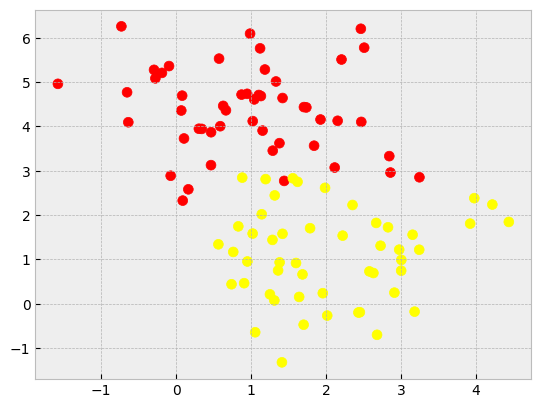

In [21]:
X, t = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1)
plt.scatter(X[:, 0], X[:, 1], c=t, s=50, cmap='autumn');

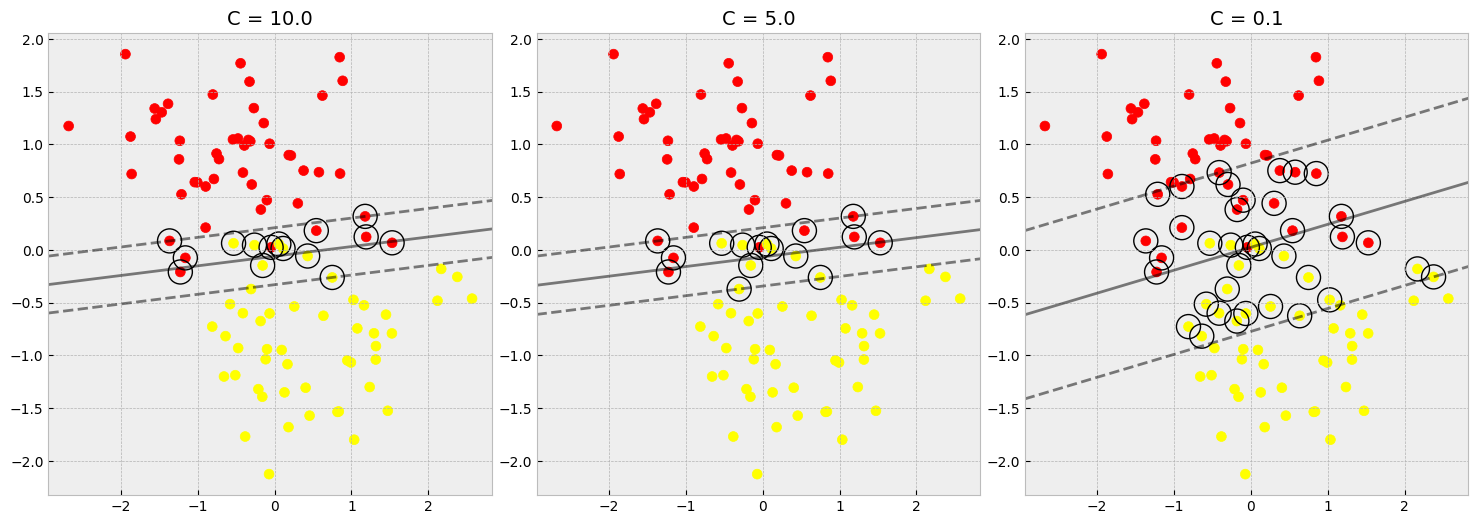

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

scaler=StandardScaler()
X=scaler.fit_transform(X)


for axi, C in zip(ax, [10, 5, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, t)
    axi.scatter(X[:, 0], X[:, 1], c=t, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

Here is a **super-easy baby-language explanation** of what this code is doing.
I will explain **block by block**, very simply.

---

# 🧸 **What this code does (big idea)**

It draws **3 SVM plots side-by-side**
Each plot uses a **different C value** → so you can **see how margin changes**.

* Big C → strict → hard margin
* Medium C → balanced
* Small C → soft margin

---

# 🍼 **Line-by-line simple explanation**

---

## ✅ **1. Create a row of 3 empty plots**

```python
fig, ax = plt.subplots(1, 3, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
```

🍼 Meaning:

* Make **1 row**, **3 columns** of plots.
* Make the figure wider.
* Adjust spacing so they don’t touch.

---

## ✅ **2. Scale the data**

```python
scaler=StandardScaler()
X=scaler.fit_transform(X)
```

🍼 Meaning:

* StandardScaler makes the data **mean = 0**, **std = 1**
* SVM needs scaling to work well.

---

## ✅ **3. Loop through each axis and each C value**

```python
for axi, C in zip(ax, [10, 5, 0.1]):
```

🍼 Meaning:

* `axi` = one of the 3 plots
* `C` takes values `10`, `5`, and `0.1`
* So, for each plot, try a different C.

---

## ✅ **4. Train the SVM with the chosen C**

```python
model = SVC(kernel='linear', C=C).fit(X, t)
```

🍼 Meaning:

* Train a **linear SVM** on the scaled data.
* Use the current value of C.

---

## ✅ **5. Plot the data points**

```python
axi.scatter(X[:, 0], X[:, 1], c=t, s=50, cmap='autumn')
```

🍼 Meaning:

* Draw the points (X) colored by their label (t).

---

## ✅ **6. Draw the decision boundary + margins**

```python
plot_svc_decision_function(model, axi)
```

🍼 Meaning:

* Draw:

  * the decision line (0)
  * the margins (+1 and -1)

This uses the helper function you sent earlier.

---

## ✅ **7. Draw support vectors with big circles**

```python
axi.scatter(model.support_vectors_[:, 0],
            model.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');
```

🍼 Meaning:

* Mark the **support vectors** with big empty circles.

These are the important points that define the SVM boundary.

---

## ✅ **8. Add the title for each plot**

```python
axi.set_title('C = {0:.1f}'.format(C), size=14)
```

🍼 Meaning:

* Title of each subplot is:

  * “C = 10.0”
  * “C = 5.0”
  * “C = 0.1”

So you can compare the effect of C.

---

# 🎉 Final Baby Summary

**This code draws 3 SVM plots side by side.
Each one uses a different C value to show how strict or soft the margin is.**

* **C = 10** → very strict → narrow margin → many support vectors
* **C = 5** → medium strictness
* **C = 0.1** → very soft → wide margin → allows more mistakes

This helps you visually understand how SVM margin changes with C.

---

If you want, I can also add a diagram or cartoon-style explanation of what C does.


---

#NOTES
Great question — and **YES, that’s the correct intuition**, but let me explain it clearly so you never forget it 👇

---

# ✅ **SVM Classification vs SVM Regression: Where Are the Support Vectors?**

---

# 🔹 **SVM Classification → Support Vectors are OUTSIDE the margin**

### Why?

In classification, we want a **maximum margin** between the two classes.

* The margin is the space **between the two dotted boundary lines**.
* Support vectors are the **closest points FROM EITHER CLASS that lie on or outside the margin boundaries**.
* They **support** (define) the margin.

### So:

✔ They lie **on the margin boundary**
✔ Or sometimes **outside** if they are misclassified (soft margin)
❌ Never inside the margin (for perfect separation)

---

# 🔹 **SVR (Support Vector Regression) → Support Vectors are INSIDE or ON the ε-tube**

### Why?

In SVR, instead of maximizing margins, we want to **fit a regression curve with tolerance (epsilon)**.

* There is an **ε-tube** around the regression function.
* Any point **inside the tube** = no penalty
* Points **outside the tube** = become support vectors

### So:

✔ Support vectors = points **lying OUTSIDE the ε-tube**
✔ Points inside the tube are ignored (not support vectors)
✔ The tube = region of “acceptable error”

---

# ⭐ **Simple Summary**

| Concept         | Classification SVM                           | Regression SVM (SVR)                         |
| --------------- | -------------------------------------------- | -------------------------------------------- |
| Region          | Margin                                       | ε-tube                                       |
| Support Vectors | Points **on/just outside** margin boundaries | Points **outside** the ε-tube (error zone)   |
| Goal            | Maximize margin                              | Keep errors within ε, penalize those outside |

---

# 🧠 Super Simple Memory Trick

* **Classification margin = like two boundaries → SVs touch the boundary.**
* **Regression ε-tube = like a tunnel → SVs are the ones that fall *outside* the tunnel.**

---

If you want, I can draw a simple ASCII-style diagram or give you Python code to visualize classification margin vs regression ε-tube.


Here is the **clean, simple, and student-friendly** explanation you need 👇

---

# ✅ **Difference Between Linear vs Non-Linear SVM (Classification & Regression)**

---

# 🔹 **1. Linear SVM (Classification)**

### **When data is linearly separable**

A **linear SVM classifier** finds a **straight-line (2D) or flat hyperplane (n-D)** to separate classes.

### **Characteristics**

* Decision boundary = **straight line**
* Works well when classes can be separated without curves
* Faster to train
* Less risk of overfitting

### **Kernel used:**

`kernel='linear'`

### **Example**

Two classes can be separated by a straight line → linear SVM works perfectly.

---

# 🔹 **2. Non-Linear SVM (Classification)**

### **When data is *not* linearly separable**

A **non-linear SVM classifier** uses kernels to draw a **curved or complex boundary**.

### **Characteristics**

* Decision boundary = **curve / circle / complex shape**
* Uses kernel trick to map data into higher dimensions
* More powerful, but more risk of overfitting
* Slower than linear SVM

### **Common kernels**

* `rbf`
* `poly`
* `sigmoid`

### **Example**

Classes are mixed in a circular pattern → needs a curved boundary → non-linear SVM.

---

# 🔥 **MAIN DIFFERENCE — Classification**

| Aspect            | Linear SVM                 | Non-Linear SVM           |
| ----------------- | -------------------------- | ------------------------ |
| Decision Boundary | Straight line              | Curved/complex           |
| Kernel            | No kernel or linear kernel | RBF, Polynomial, Sigmoid |
| Speed             | Fast                       | Slower                   |
| Best For          | Linearly separable data    | Complex patterns         |

---

# ⭐ Now for Regression (SVR)

---

# 🔹 **3. Linear SVR (Support Vector Regression)**

### **When relationship between X and y is approximately linear**

It fits a **straight line** within an ε-tube (margin) to predict continuous values.

### **Characteristics**

* Simple linear relationship
* Very fast
* Lower variance, higher bias

### **Kernel used:**

`kernel='linear'`

---

# 🔹 **4. Non-Linear SVR (RBF / Polynomial)**

### **When relationship is curved or complex**

SVR uses **kernel trick** to fit **curved regression lines**.

### **Characteristics**

* Captures complex trends
* More flexible and accurate
* Higher risk of overfitting
* Slower

### **Kernels used:**

`kernel='rbf'`, `kernel='poly'`

---

# 🔥 **MAIN DIFFERENCE — Regression**

| Aspect                    | Linear SVR    | Non-Linear SVR          |
| ------------------------- | ------------- | ----------------------- |
| Model Shape               | Straight line | Curved function         |
| Captures Complex Patterns | ❌ No          | ✅ Yes                   |
| Speed                     | Fast          | Slower                  |
| Best For                  | Linear trend  | Complex nonlinear trend |

---

# 🧠 **In One Line**

* **Linear SVM/SVR → straight boundary/line → fast → simple relationship**
* **Non-Linear SVM/SVR → curved boundary/function → powerful → handles complex data**

---

# If you want, I can also explain:

✅ with graphs generated in Python
✅ with full code for linear vs RBF SVM and SVR
✅ or quick MCQ-style revision notes

Just tell me!


# SVM for Regression Tasks

The SVM algorithm not only does it support linear and nonlinear classification, but it also supports linear and nonlinear regression. To use SVMs for regression instead of classification, the trick is to reverse the objective: instead of trying to fit the largest possible street between two classes while limiting margin violations, SVM Regression tries to fit as many samples as possible on the street while limiting margin violations (i.e., samples *off* the street). The width of the street is controlled by a hyperparameter, $\epsilon$. EPSILON 

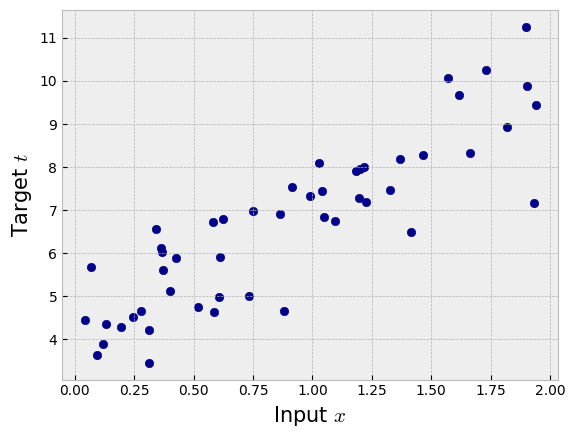

In [23]:
np.random.seed(42)
X = 2 * np.random.rand(50, 1)
t = 4 + 3 * X[:, 0] + np.random.randn(50)

plt.scatter(X, t, c='darkblue')
plt.xlabel('Input $x$',size=15)
plt.ylabel('Target $t$', size=15);

In [33]:
from sklearn.svm import SVR

svm_reg = Pipeline([('scaler',StandardScaler()),
                    ('svm',SVR(kernel='linear',
                               epsilon=0.5))]) #if a point is within ±0.5 from the line, I will NOT punish it.
svm_reg.fit(X, t)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVR(epsilon=0.5, kernel='linear'))])

In [37]:
def find_support_vectors(svm_reg, X, t):
    y_pred = svm_reg.predict(X)
    epsilon = svm_reg[-1].epsilon
    off_margin = np.abs(t - y_pred) >= epsilon
    return np.argwhere(off_margin)

def plot_svm_regression(svm_reg, X, t, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    epsilon = svm_reg[-1].epsilon
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"Mapper", zorder=-2)
    plt.plot(x1s, y_pred + epsilon, "k--", zorder=-2)
    plt.plot(x1s, y_pred - epsilon, "k--", zorder=-2)
    plt.scatter(X[svm_reg._support], t[svm_reg._support], s=180,
                facecolors='#AAA', zorder=-1)
    plt.plot(X, t, "bo")
    plt.xlabel("Input $x$",size=15)
    plt.legend(loc="upper left")
    plt.axis(axes)



In [26]:
svm_reg2 = Pipeline([('scaler',StandardScaler()),
                    ('svm',SVR(kernel='linear',
                               epsilon=1.5))])
svm_reg2.fit(X, t)

svm_reg._support = find_support_vectors(svm_reg, X, t)
svm_reg2._support = find_support_vectors(svm_reg2, X, t)

eps_x1 = 1
eps_y_pred = svm_reg2.predict([[eps_x1]])

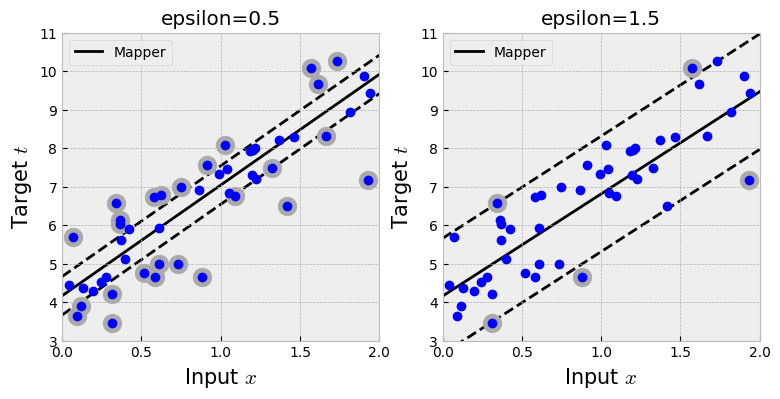

In [27]:
plt.figure(figsize=(9,4))
plt.subplot(1,2,1); plot_svm_regression(svm_reg, X, t, [0, 2, 3, 11])
plt.ylabel("Target $t$",size=15)
plt.title(f"epsilon={svm_reg[-1].epsilon}")

plt.subplot(1,2,2); plot_svm_regression(svm_reg2, X, t, [0, 2, 3, 11])
plt.ylabel("Target $t$",size=15)
plt.title(f"epsilon={svm_reg2[-1].epsilon}");

Adding more training samples within the margin does not affect the model’s predictions; thus, the model is said to be $\epsilon$-insensitive.

To tackle nonlinear regression tasks, you can use a kernelized SVM model.

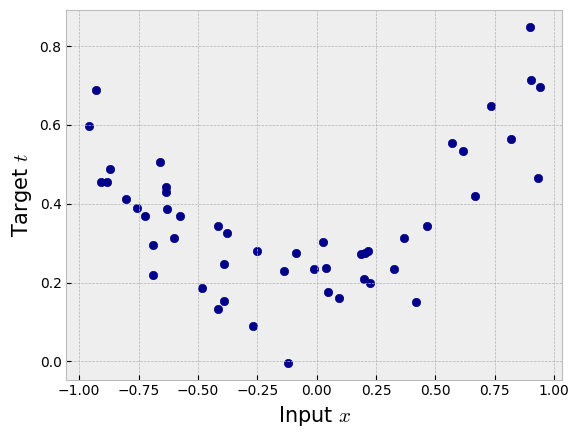

In [28]:
# extra code – these 3 lines generate a simple quadratic dataset
np.random.seed(42)
X = 2 * np.random.rand(50, 1) - 1
t = 0.2 + 0.1 * X[:, 0] + 0.5 * X[:, 0] ** 2 + np.random.randn(50) / 10

plt.scatter(X, t, c='darkblue')
plt.xlabel('Input $x$',size=15)
plt.ylabel('Target $t$', size=15);

In [29]:
svm_poly_reg = Pipeline([('scaler',StandardScaler()),
                         ('svm',SVR(kernel='poly', 
                                    degree=2, 
                                    C=0.01, 
                                    epsilon=0.1))])
svm_poly_reg.fit(X, t)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVR(C=0.01, degree=2, kernel='poly'))])

In [30]:
svm_poly_reg2 = Pipeline([('scaler',StandardScaler()),
                         ('svm',SVR(kernel='poly', 
                                    degree=2, 
                                    C=100, 
                                    epsilon=0.1))])
svm_poly_reg2.fit(X, t)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVR(C=100, degree=2, kernel='poly'))])

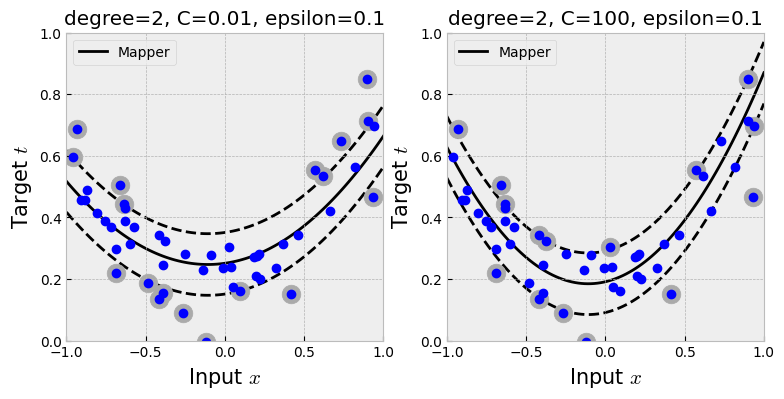

In [31]:
svm_poly_reg._support = find_support_vectors(svm_poly_reg, X, t)
svm_poly_reg2._support = find_support_vectors(svm_poly_reg2, X, t)

plt.figure(figsize=(9,4))
plt.subplot(1,2,1); plot_svm_regression(svm_poly_reg, X, t, [-1, 1, 0, 1])
plt.ylabel("Target $t$",size=15)
plt.title(f"degree={svm_poly_reg[-1].degree}, "
          f"C={svm_poly_reg[-1].C}, "
          f"epsilon={svm_poly_reg[-1].epsilon}")

plt.subplot(1,2,2); plot_svm_regression(svm_poly_reg2, X, t, [-1, 1, 0, 1])
plt.ylabel("Target $t$",size=15)
plt.title(f"degree={svm_poly_reg2[-1].degree}, "
          f"C={svm_poly_reg2[-1].C}, "
          f"epsilon={svm_poly_reg2[-1].epsilon}");

---

In [32]:
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, AdaBoostRegressor
from sklearn.metrics import r2_score
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split

# Exercise 1

**Consider the performance of 5 regression algorithms (A, B, C, D and E) on the two datasets presented in the figure below.**

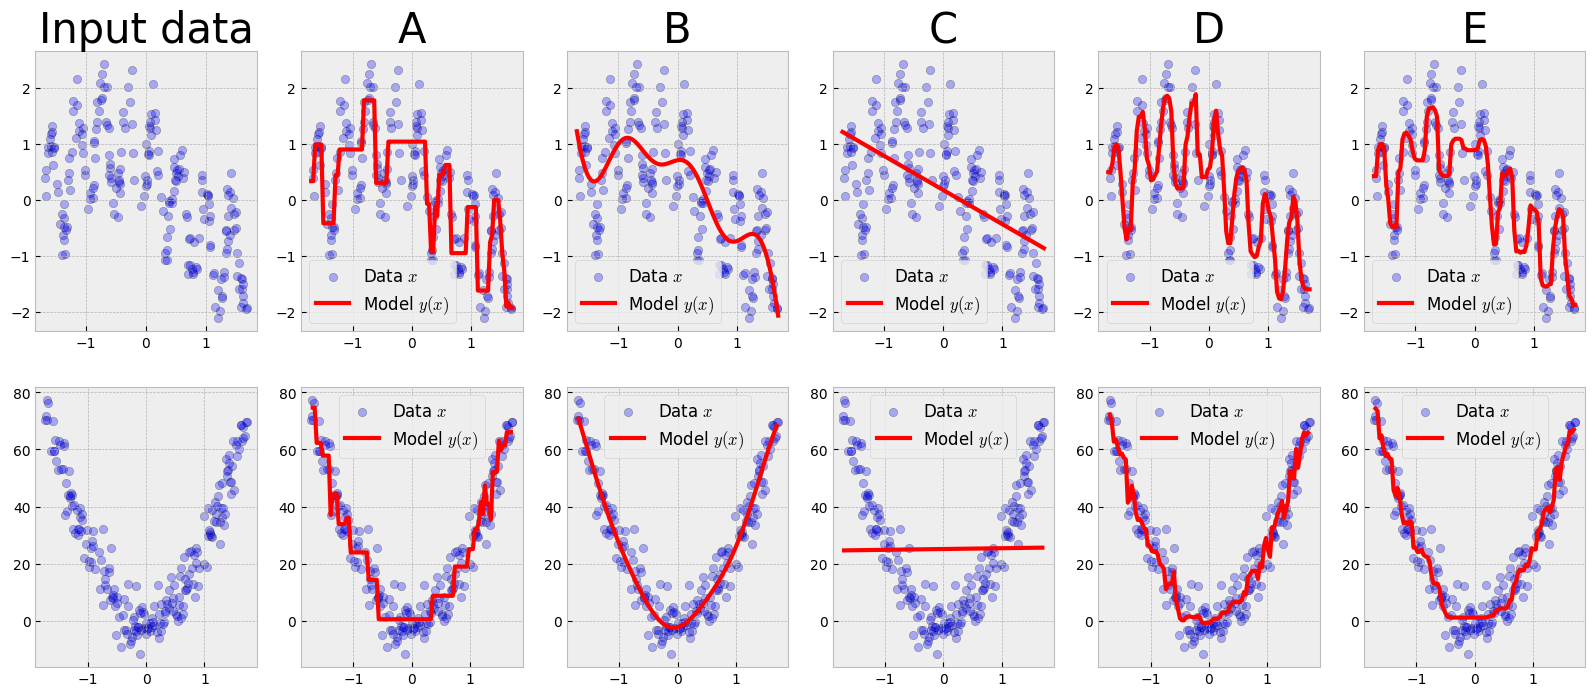

In [38]:
# figure parameters
h = .02  # step size in the mesh
figure = plt.figure(figsize=(20,8))

# set up regressors
regressors = [DecisionTreeRegressor(max_depth=5),
              SVR(C=100),
              LinearRegression(),
              AdaBoostRegressor(RandomForestRegressor(max_depth=5, n_estimators=10, max_features=1),
                                  n_estimators=100, learning_rate=1,random_state=0),
             RandomForestRegressor(max_depth=5, n_estimators=100, max_features=1)]

names = ['A', 'B', 'C', 'D', 'E']

# Put together Data Sets
n_samples = 300
rng = np.random.RandomState(42)
X = 10 * rng.rand(n_samples)
sigma=0.3
t = np.sin(5 * X) + np.sin(0.5 * X) + sigma * rng.randn(len(X))
fast_and_slow_oscillation = (X.reshape(-1,1),t)

X = np.linspace(0,10,n_samples)
t = 3*(X-5)**2 + 6* np.random.randn(n_samples)
noisy_quadratic=(X.reshape(-1,1),t)

datasets = [fast_and_slow_oscillation, noisy_quadratic]

i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, t = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, t_train, t_test = train_test_split(X, t, 
                                                        test_size=.3, 
                                                        random_state=42)
    # Synthetic data for plotting
    xx = np.linspace(-1.7,1.7,100).reshape(-1,1)
    yy = np.linspace(-1.7,1.7,100).reshape(-1,1)
    
    ax = plt.subplot(len(datasets), len(regressors) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data", fontsize=30)
    # Plot the training points
    plt.scatter(X_train, t_train, c='blue', alpha=0.3, edgecolors='k',label='Training points')
    i += 1

    # iterate over regressors
    for name, reg in zip(names, regressors):
        ax = plt.subplot(len(datasets), len(regressors) + 1, i)
        
        # Training regressor
        reg.fit(X_train, t_train)
        
        # Making predictions
        y_train = reg.predict(X_train)
        y_test = reg.predict(X_test)
        
        # r2-score in test
        score = r2_score(t_test, y_test)

        # Plot the predictions
        ax.scatter(X_train, t_train, c='blue', alpha=0.3, edgecolors='k',label='Data $x$')
        ax.plot(xx, reg.predict(xx), 'red', linewidth=3, label='Model $y(x)$')
        
        ax.legend(fontsize=12)
        if ds_cnt == 0:
            ax.set_title(name, fontsize=30)
        i += 1

**The algorithms used to produce these plots (in no particular order) are: linear regression, decision trees, random forests (with 100 trees), AdaBoost (with 100 estimators) and SVM (RBF kernel and $C=100$). Which performance (A, B, C, D or E) corresponds to which regressor? Justify your choices.**

* Performance C corresponds to linear regression. This is clear from its linear mapper predictor.
*  Performance A corresponds to decision tree. We can see in the estimated mapper function the cuts in the decision tree as they are parallel to the canonical axis. Moreover, the performance is too weaker compared to what we expect random forests and AdaBoost to produce.
* Performance E corresponds to random forest. Wee see that the estimated mapper function is more complex than that of the decision tree (mapper A) but still underfitting. This is a common characteristic of random forest - try to reduce overfitting/variance.
* Performance D corresponds to AdaBoost. In the case of AdaBoost it will have more variance/overfitting compared to random forests. This mapper function indicates this behavior as it is fitting the most training samples, producing a more complex algorithm.
* Lastly, performance B corresponds to the SVM performance as indicative by the smoothness and non-linearity of the fitting.

# Exercise 2

**Consider the performance of 5 classification algorithms (A, B, C, D and E) on the three datasets presented in the figure below.**

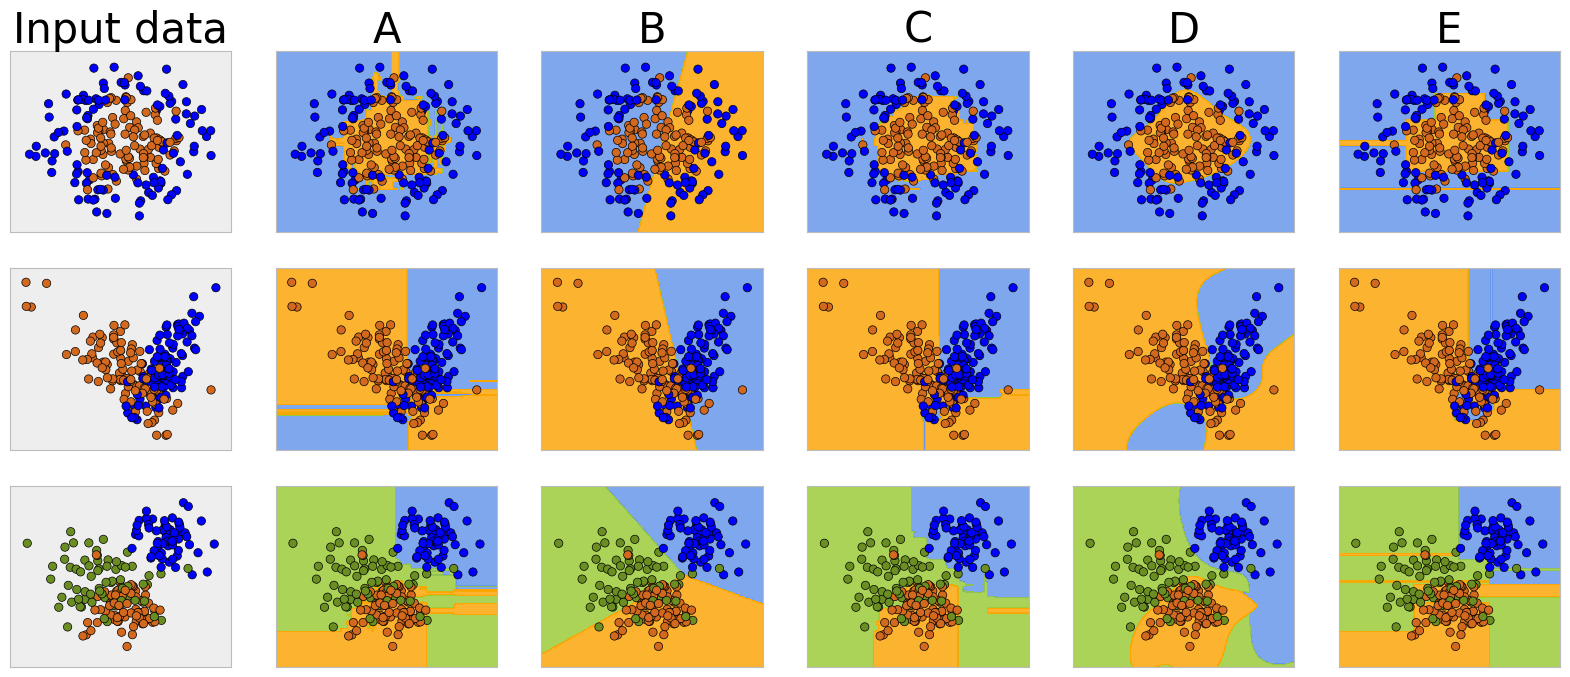

In [39]:
# figure parameters
h = .02  # step size in the mesh
figure = plt.figure(figsize=(20, 8))

# set up classifiers
classifiers = [AdaBoostClassifier(RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
                                  n_estimators=100, learning_rate=1,random_state=0,algorithm='SAMME'),
               LogisticRegression(multi_class='multinomial'),
               RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1),
               SVC(C=100),
               DecisionTreeClassifier(max_depth=5)
              ]

names = ['A', 'B', 'C', 'D', 'E']

# Put together Data Sets
n_samples = 300
X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 1*rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_circles(noise=0.2, factor=0.5, random_state=1,n_samples=n_samples),
            linearly_separable,
            make_blobs(random_state=1,cluster_std=[3.0,4.0,2.5],n_samples=n_samples)
            ]
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = ListedColormap(['cornflowerblue','yellowgreen','orange']) #plt.cm.RdBu
    cm_bright = ListedColormap(['blue','olivedrab','chocolate'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data", fontsize=30)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k',label='Training points')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
#     ax.legend()
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name, fontsize=30)
        i += 1

Here is the **correct mapping of A–E to the classifiers**, with **clear justification** for each one.

---

# ✅ **Classifiers Given**

You must match each visualization (A–E) to:

1. **Logistic Regression**
2. **Decision Tree**
3. **Random Forest (100 trees)**
4. **AdaBoost (100 estimators)**
5. **SVM (RBF kernel, C = 100)**

---

# 🔍 **Quick Visual Reasoning Rules**

Before matching, remember how each model behaves:

### **1️⃣ Logistic Regression**

* ALWAYS **linear** decision boundary.
* Straight lines separating classes.
* No curves, no complex borders.

### **2️⃣ Decision Tree**

* Axis-aligned **rectangular splits**.
* Boundaries look like **vertical/horizontal blocks**.
* Often overfits with sharp boxy regions.

### **3️⃣ Random Forest**

* Many trees → **smoother**, but still blocky.
* Boundaries are **piecewise-rectangular**, but smoother and less noisy than a single tree.

### **4️⃣ AdaBoost**

* Produces **many tiny rectangular regions**.
* Highly irregular boundaries.
* Very sensitive to noise and outliers.

### **5️⃣ SVM with RBF Kernel**

* Produces **smooth curved boundaries**.
* Flexible but **not blocky**.
* Typically the smoothest non-linear model.

--------------


**The algorithms used to produce these plots (in no particular order) are: logistic regression, decision trees, random forests (with 100 trees), AdaBoost (with 100 estimators) and SVM (RBF kernel and $C=100$). Which performance (A, B, C, D or E) corresponds to which classifier? Justify your choices.**

* Decision surface B corresponds to logistic regression. This is indicative from the linear boundaries between pairs of classes.
* Decision surface E corresponds to decision tree. This is clearly from the cuts parallel to the canonical axis but also from the high-variance regions it produces to acomodate a small amount of samples.
* Decision surface C corresponds to random forests. We see tht the cuts are still parallel to the canonical axis but the decision surface produces a more generalizable performance.
* Decision surface A correpsonds to AdaBoost. This is indicative clearly in the performance of the 2nd dataset (2nd row), as the model tries to learn the lower center region of class blue. AdaBoost will produce a more complex model that may overfit more than that of a random forest.
* Decision surface D corresponds to SVM. This is indicative but its non-linear decision surface.

---

# The Curse of Dimensionality 

The Curse of Dimensionality illustrates various phenomena that arise when we work with high-dimensional data spaces that would not otherwise occur in lower-dimensional settings (such as the 3-dimensional space).

> ## Our intuitions do not hold in high-dimensional spaces 🤔

Let's illustrate this with two examples.

## Example 1: Volume of a Crust

Consider two embedded spheres, $S_1$ and $S_2$, where sphere $S_1$ has radius $r$, sphere $S_2$ has radius $r-\epsilon$, with $0<\epsilon<r$.

Let's calculate the ratio between the volume of the crust and the volume of the outer sphere $S_1$:

\begin{align*}
\text{ratio} = \frac{V_{crust}}{V_{S_1}} = \frac{V_{S_1} - V_{S_2}}{V_{S_1}}
\end{align*}

* The $D$-dimensional [volume of a sphere of radius $r$ in $D$-dimensional space](https://en.wikipedia.org/wiki/Volume_of_an_n-ball) is: $V = \frac{r^D \pi^{\frac{D}{2}}}{\Gamma\left(\frac{D}{2}+1\right)}$, then

\begin{align*}
\text{ratio} &= \frac{V_{S_1} - V_{S_2}}{V_{S_1}} \\
&= 1-\frac{V_{S_2}}{V_{S_1}} \\
&= 1-\frac{\frac{(r-\epsilon)^D \pi^{\frac{D}{2}}}{\Gamma\left(\frac{D}{2}+1\right)}}{\frac{r^D \pi^{\frac{D}{2}}}{\Gamma\left(\frac{D}{2}+1\right)}} \\
&= 1 - \frac{(r-\epsilon)^D}{r^D}\\
&= 1 - \frac{r^D\left(1-\frac{\epsilon}{r}\right)^D}{r^D}\\
&= 1 - \left(1-\frac{\epsilon}{r}\right)^D
\end{align*}

* For a fixed value for $\epsilon$, a fixed radius $r$ and $\epsilon<r$, what happens as $D$ increases?

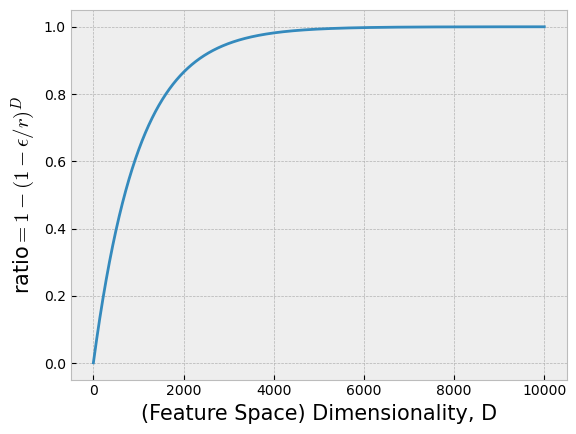

In [ ]:
# Crust volume between spheres with epsilon different radii and increasing dimensionality

r = 1 # radius of outer sphere
eps = 0.001 # epsilon value
D = range(1,10000) # dimensionality
RatioVol = [1-(1-eps/r)**d for d in D] # ratio of the volume as a function of dimensionality D
plt.plot(D, RatioVol) # plotting results
plt.ylabel('ratio$=1 - (1 - \epsilon/r)^D$',size=15)
plt.xlabel('(Feature Space) Dimensionality, D',size=15);

> ## 🤯 Let's see another example!

## Example 2: Unit Porcupine

Consider the unit porcupine which is represented as a unit hypersphere inscribed within a unit hypercube.

Recall that the $D$-dimensional volume of a $D$-dimensional cube with radius $r$ is $(2r)^D$.

* What happens to the ratio between the volume of the sphere and the volume of the cube as dimensionality $D$ increases?

\begin{align*}
\frac{V(\text{sphere})}{V(\text{cube})} &= \frac{\frac{r^D \pi^{\frac{D}{2}}}{\Gamma\left(\frac{D}{2}+1\right)}}{(2r)^D}\\
&= \frac{r^D \pi^{\frac{D}{2}}}{(2r)^D\Gamma\left(\frac{D}{2}+1\right)}\\
&= \frac{\pi^{\frac{D}{2}}}{2^D\Gamma\left(\frac{D}{2}+1\right)}
\end{align*}

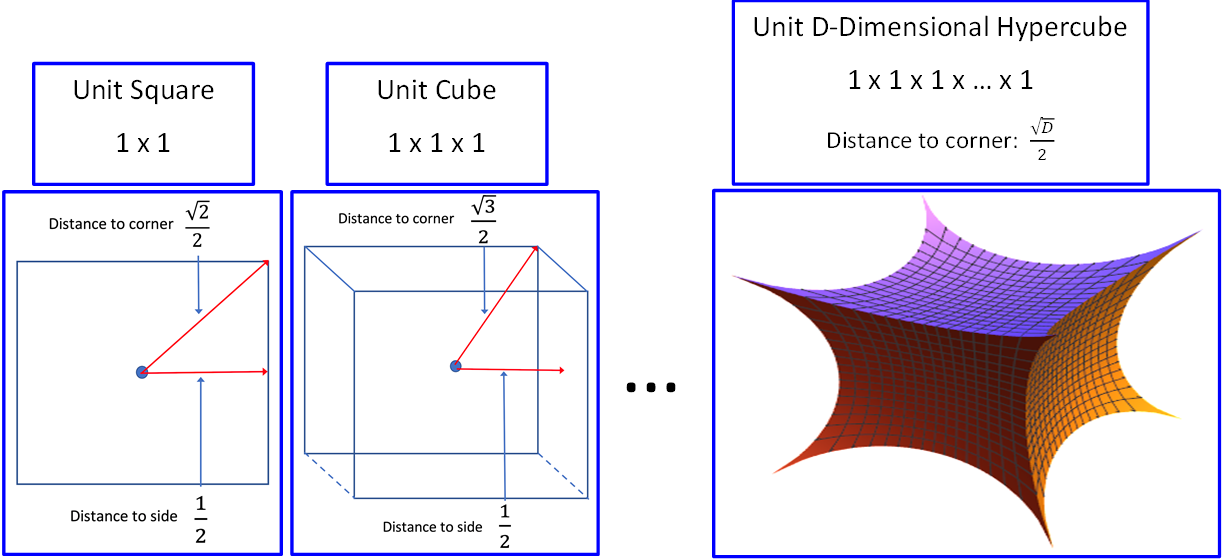

In [ ]:
from IPython.display import Image
Image('figures/hypercube.png',width=1000)

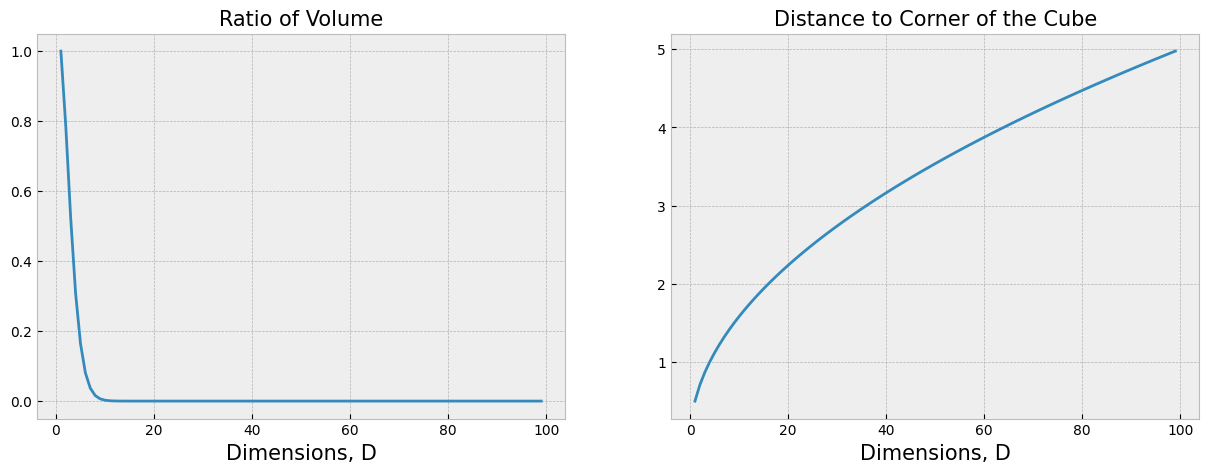

In [40]:
# The Unit Porcupine (the unit hyper-sphere inscribed within the unit hyper-cube)
import math

D = range(1,100) # dimensionality, D
V = [np.pi**(i/2)/(2**i*math.gamma(i/2 + 1)) for i in D] # ratio as a function of dimensionality D
dist_to_Corner = [math.sqrt(d)/2 for d in D] # distance 

# plotting
plt.figure(figsize=(15,5))
plt.subplot(1,2,1); plt.plot(D, V) 
plt.title('Ratio of Volume',size=15)
plt.xlabel('Dimensions, D',size=15)

plt.subplot(1,2,2)
plt.plot(D, dist_to_Corner) 
plt.title('Distance to Corner of the Cube',size=15)
plt.xlabel('Dimensions, D',size=15);

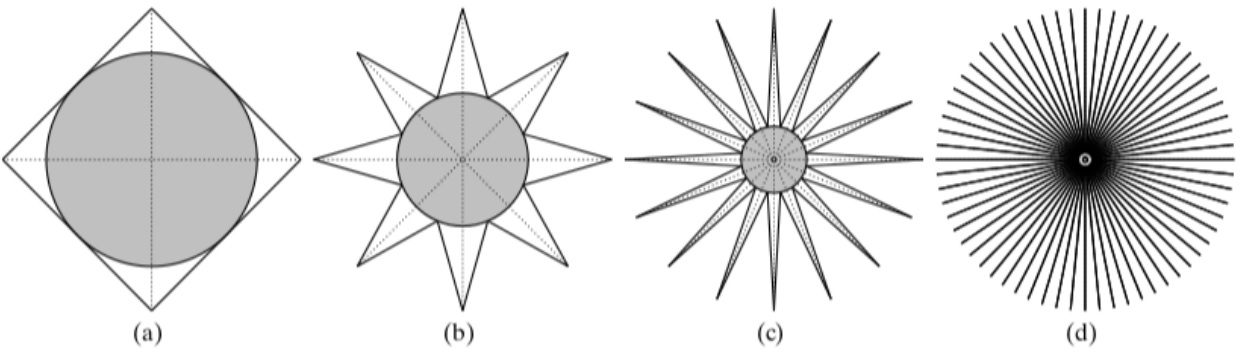

In [ ]:
Image('figures/Unit Porcupine.jpg',width=800)

1. Volume of the Crust

In high dimensions, almost all volume lies near the boundary, making space empty inside → needs huge data.

2. Porcupine Effect / Unit of Porcupine

Points become almost equally far, directions become orthogonal, destroying “nearness”.

___

## Discussions

In the unit porcupine example, for higher-dimensionality $D$, all of the volume will reside in the "corners". So, distances between neighboring points is extremely large. The notion of **similarity** as measure by distances becomes a challenge.

As the dimensionality of the feature space increases, we need exponentially more data in order to explain a highly increasing volume.

We need to be careful choosing a model as that choice "injects" what we want the data to look like or follow a specific behavior. For example, in higher-dimensions, the tails of a Gaussian density function will become highly dense.

Always employ the **Occam's Razor** principle: the simplest model that works for our data is usually the most appropriate and sufficient. Model simplicity can mean different things, but we can consider a model to be complex if it has too many hyperparameter values to configure. 

When we are in a high-dimensional input space (such as images), much of that space is empty. The input data can be represented in only a few *degrees of freedom* of variability. We say that the data in *embedded* in a **manifold** of equal dimensionality as the degrees of freedom (which is drastically smaller than the input space dimensionality). We will study a few dimensionality reduction and manifold learning techniques later on in this course.

And again, intuitions or assumptions do not always hold in higher dimensions.

___

The sentence means this, in simple words:

# ✅ **When you go to higher dimensions, your normal intuitions stop working.**

Things that feel obvious in 2D or 3D **do NOT behave the same** in 50D, 100D, or 1000D.

---

# 🔍 Example Intuitions That Fail in High Dimensions

### ❌ **Intuition: Most points are near the center.**

In high dimensions, **almost all points lie near the boundary** (“volume of the crust”).

### ❌ **Intuition: Some points will be close together.**

In high dimensions, **all distances become almost equal** (porcupine effect).

### ❌ **Intuition: Data will be dense enough.**

In high dimensions, **space becomes exponentially empty**, and you need way more data.

### ❌ **Intuition: A simple model will generalize well.**

High-dimensional models easily **overfit**, even with simple methods like k-NN.

---

# ⭐ One-Line Meaning

**Your usual geometric intuition breaks down in high-dimensional spaces.**

---

If you want, I can explain this with simple visual examples or 1–2 line exam answers.
